In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
from datetime import timedelta

dfCaudal = pd.read_excel(r'caudal.xlsx')
dfCaudal = pd.DataFrame(dfCaudal, columns=['Tempo', 'Caudal'])

dfCaudal.head()

,Tempo,Caudal
0,2020-01-01 23:26:58,4.39
1,2020-01-02 00:26:58,3.9
2,2020-01-02 01:26:58,3.6
3,2020-01-02 02:26:58,3.3
4,2020-01-02 03:26:54,3.3


In [4]:
dfInterv = pd.read_excel(r'ordens.xlsx', sheet_name="Intervenções")
dfInterv.drop(dfInterv.columns[[2, 3, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18,19,20,22, 23, 24, 25]], inplace=True, axis=1)
dfInterv.rename( columns = {
    'INTERVENÇÕES': 'intervencao',
    'Unnamed: 1': 'data',
    'Unnamed: 4': 'dataexecucao',
    'Unnamed: 6': 'duracao',
    'Unnamed: 11': 'sintoma',
    'Unnamed: 21': 'zmc',
}, inplace=True)
dfInterv = dfInterv.iloc[1:, :]
dfInterv = dfInterv[dfInterv.zmc == 'ZMC de Bolho']
dfInterv = dfInterv[dfInterv.sintoma.str.contains('Fuga')]
dfInterv['data'] = pd.to_datetime(dfInterv['data'])
dfInterv['dataexecucao'] = pd.to_datetime(dfInterv['dataexecucao'])
# TODO
# avaliar diferenca de todas 
# avaliar apenas aquelas q sao fugas no ramal

dfInterv.head(20)

,intervencao,data,dataexecucao,duracao,sintoma,zmc
64,IN_22_AB_03260,2022-08-29 07:45:00,2022-08-29 15:43:40,00:42:12,Abastecimento » Contador » Fuga no Ramal,ZMC de Bolho
98,IN_22_AB_02934,2022-08-08 07:45:00,2022-08-08 16:03:02,01:07:34,Abastecimento » Contador » Fuga no Ramal,ZMC de Bolho
148,IN_22_AB_02372,2022-07-01 07:45:00,2022-07-01 14:02:27,00:01:55,Abastecimento » Contador » Fuga no Ramal,ZMC de Bolho
155,IN_22_AB_02280,2022-06-27 08:00:00,2022-06-27 15:57:53,00:04:00,Abastecimento » Contador » Fuga no Ramal,ZMC de Bolho
199,IN_22_AB_01782,2022-05-20 07:45:00,2022-05-20 15:02:49,01:10:29,Abastecimento » Contador » Fuga no Ramal,ZMC de Bolho


In [5]:
def plotCaudal(interZmc):
    timeDeltaAntes = 8
    timeDeltaDepois = 8
    dfCaudal['Caudal'] = pd.to_numeric(dfCaudal['Caudal'], errors='coerce')
    dfCaudalAposFalha = dfCaudal[dfCaudal['Tempo'] > (interZmc.dataexecucao - timedelta(hours = timeDeltaAntes))]
    dfCaudalAteExecucao= dfCaudalAposFalha[dfCaudalAposFalha['Tempo'] < (interZmc.dataexecucao + timedelta(hours = timeDeltaDepois))]

    dfCaudalAteExecucao = dfCaudalAteExecucao[dfCaudalAteExecucao['Caudal'] > 0]
    dfCaudalAteExecucao.hora = dfCaudalAteExecucao.Tempo.dt.hour
    #interZmc.dataexecucao = interZmc.dataexecucao.hour
    interZmc.hora = interZmc.data.hour
    
    #plt.axvline(x = interZmc.dataexecucao, color = 'r', label=f'{interZmc.intervencao}')
    #plt.axvline(x = interZmc.hora, color = 'b', label=f'{interZmc.intervencao}')
    
    plt.plot(dfCaudalAteExecucao.hora, dfCaudalAteExecucao.Caudal, marker='o', markevery=timeDeltaDepois, label=f'{interZmc.intervencao} {interZmc.sintoma}' )
   


C:\Users\Francisco\AppData\Local\Temp\ipykernel_25532\129659078.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfCaudalAteExecucao.hora = dfCaudalAteExecucao.Tempo.dt.hour


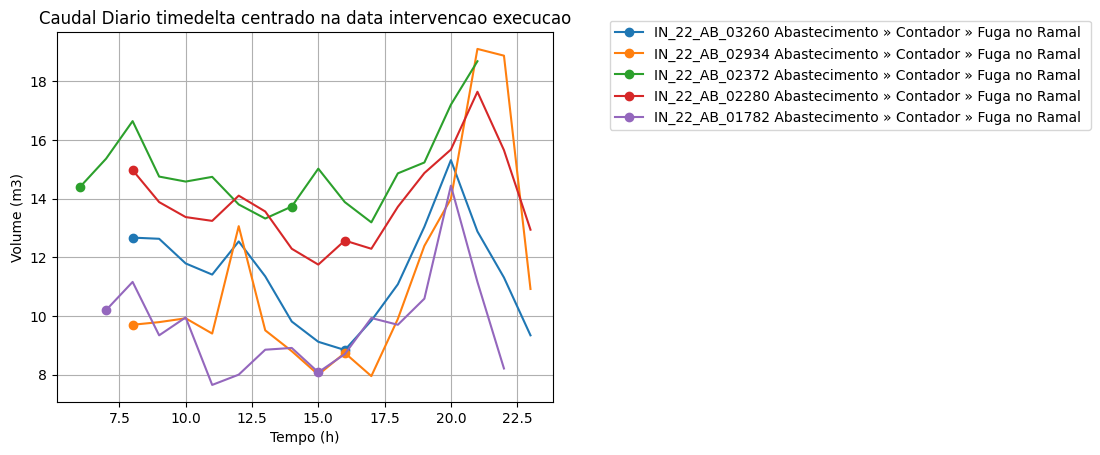

In [6]:
plt.title('Caudal Diario timedelta centrado na data intervencao execucao')
for i in range(0, len(dfInterv)):
  plotCaudal(dfInterv.iloc[i])
leg = plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel('Volume (m3)')
plt.xlabel('Tempo (h)')
plt.grid(True)



In [7]:
variacaoSemanal= dfCaudal.copy()
variacaoSemanal['weekday'] = variacaoSemanal.Tempo.dt.weekday
variacaoSemanal = variacaoSemanal.groupby('weekday').agg({'Caudal':'mean'})
variacaoSemanal.head(10)

,Caudal
weekday,
0,7.178528
1,7.139487
2,7.225430
3,7.156533
4,7.824878
5,8.274434
6,7.608919


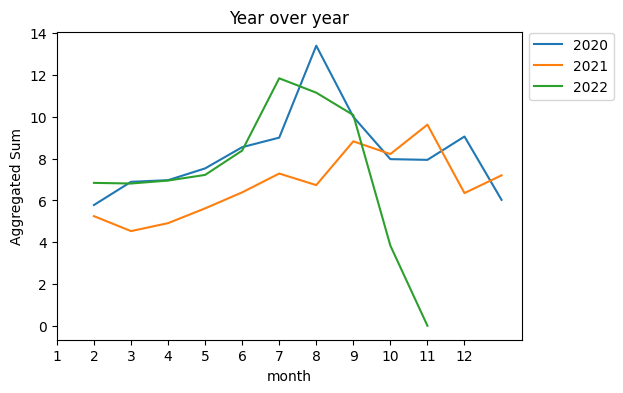

In [8]:
variacaoAnual= dfCaudal.copy()
variacaoAnual['year'] = dfCaudal.Tempo.dt.year
variacaoAnual['month'] = dfCaudal.Tempo.dt.month
variacaoAnual.set_index(["year","month"], inplace = True)

dfp = pd.pivot_table(data=variacaoAnual, index='month', columns='year', values='Caudal', aggfunc='mean')

ax = dfp.plot(ylabel='Aggregated Sum', figsize=(6, 4))
ax.set_title('Year over year')
ax.set_xticks(range(12)) # set ticks for all months
ax.set_xticklabels(dfp.index) # label all the ticks
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

<AxesSubplot: xlabel='year', ylabel='Caudal'>

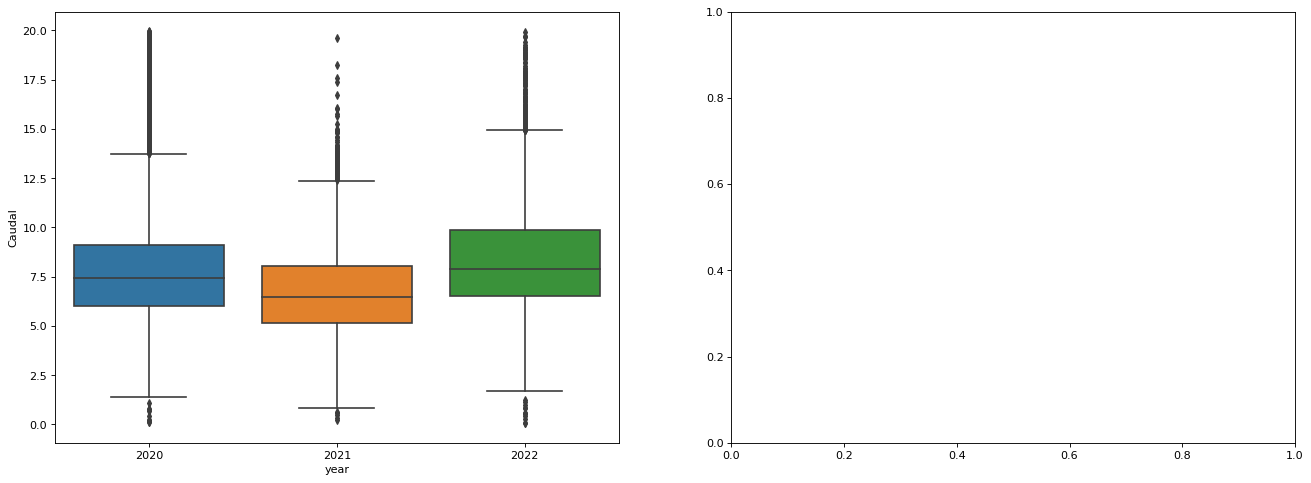

In [9]:


variacaBoxPlot = dfCaudal.copy()
variacaBoxPlot['year'] = dfCaudal.Tempo.dt.year
variacaBoxPlot['month'] = dfCaudal.Tempo.dt.month
#variacaBoxPlot.set_index(["year","month"], inplace = True)

colindex = 1
colname = variacaBoxPlot.columns[colindex]

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
#sns.boxplot(x='year', y='value', data=df, ax=axes[0])
variacaBoxPlot = variacaBoxPlot[variacaBoxPlot.Caudal < 20]
variacaBoxPlot = variacaBoxPlot[variacaBoxPlot.Caudal > 0]
sns.boxplot(x='year', y=colname, data =variacaBoxPlot, ax=axes[0])

C:\Users\Francisco\AppData\Local\Temp\ipykernel_25532\4228564964.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = dfCaudal.copy()[dfCaudal['Caudal'] > 0][dfCaudal['Caudal'] < 20][24*2:24*6] # Get part of the lines in the dataframe


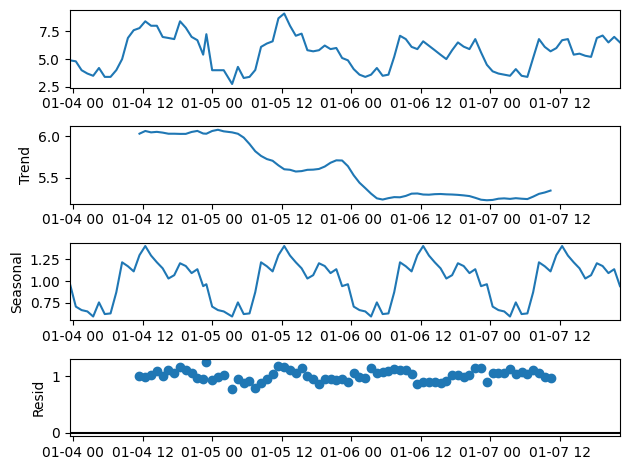

In [64]:
# seasonal decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

df1 = dfCaudal.copy()[dfCaudal['Caudal'] > 0][dfCaudal['Caudal'] < 20][24*2:24*6] # Get part of the lines in the dataframe
df1.set_index('Tempo', inplace=True)
df2 = df1[['Caudal']].copy()
decompose_result_mult = seasonal_decompose(df2,
 model="multiplicative", period=24)
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
decompose_result_mult.plot();

In [67]:
from pandas import Series
series = Series(dfCaudal['Caudal'])
series.describe()

count    24060.000000
mean         7.488471
std         10.519923
min        -75.740000
25%          5.430000
50%          7.100000
75%          8.800000
max       1434.430000
Name: Caudal, dtype: float64

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

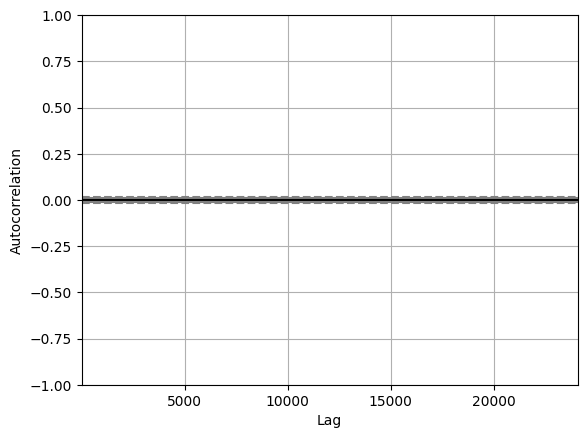

In [78]:
from pandas.plotting import autocorrelation_plot
# TODO ver o significado deste
autocorrelation_plot(series)

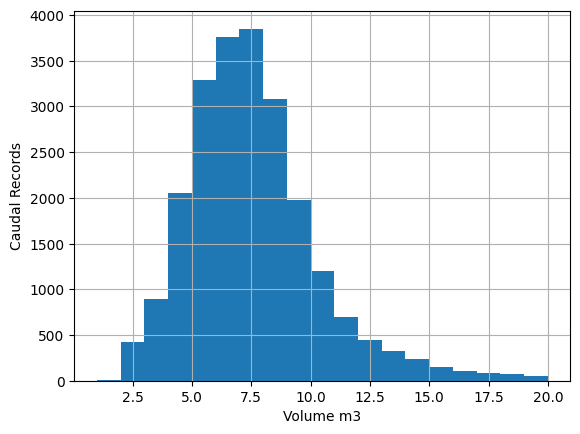

In [88]:
# separar em anos pode ajudar

#caudal total
series.hist(bins=list(range(1,20+1)))
plt.xlabel('Volume m3')
plt.ylabel("Caudal Records");